# CM3070 - Final Project
## MLNN - Deep Learning on a public dataset
## Brain Tumor Classification from MRI Scans

In [1]:
# Data manipulation and visualization
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras for deep learning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import VGG16

# Sklearn for evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from pathlib import Path

# Define the dataset directory
dataset_path = Path('data')

# Verify the dataset directory exists
if not dataset_path.exists():
    raise FileNotFoundError(f"The directory {dataset_path} does not exist.")

# Image parameters
IMAGE_HEIGHT, IMAGE_WIDTH = 150, 150
BATCH_SIZE = 32
NUM_CLASSES = 4  # glioma, meningioma, notumor, pituitary

# Data split ratios
TRAIN_SPLIT = 0.9
VALIDATION_SPLIT = 0.1

# Seed for reproducibility
SEED = 42

In [3]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT  # Reserve a portion for validation
)

# Data generator for validation (no augmentation, only rescaling)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=True,
    seed=SEED
)

# Validation data generator
validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False,
    seed=SEED
)

Found 2318 images belonging to 4 classes.
Found 256 images belonging to 4 classes.


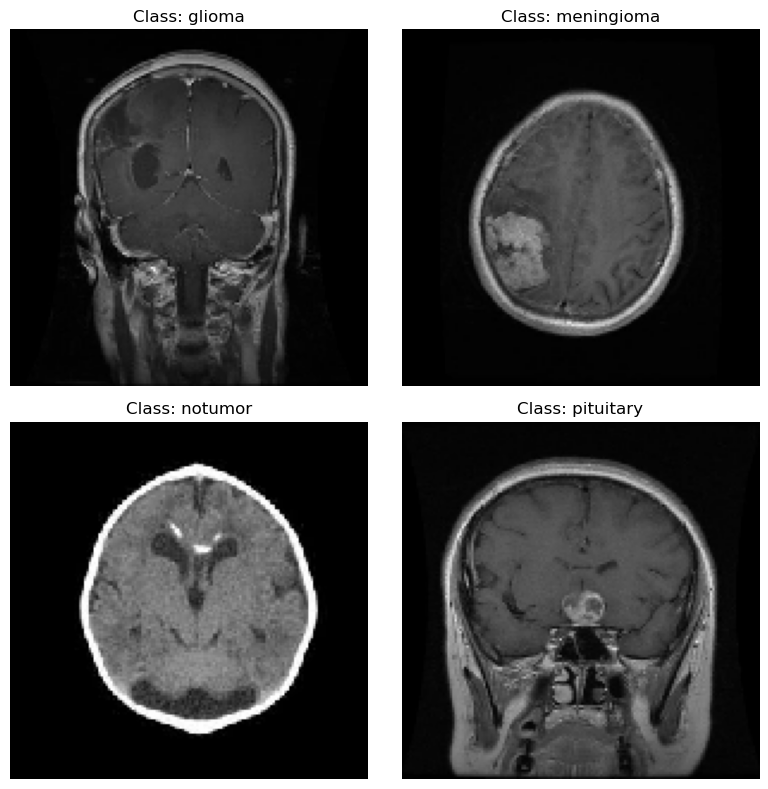

In [4]:
# Data Visualization: Display one sample image per class

import matplotlib.pyplot as plt
import numpy as np

# Map class indices to class labels
class_indices = train_generator.class_indices
label_mapping = {v: k for k, v in class_indices.items()}

# Initialize dictionaries to store sample images
sample_images = {}
sample_labels = {}

# Iterate through the validation generator
for batch_x, batch_y in validation_generator:
    for img, label in zip(batch_x, batch_y):
        if label not in sample_images:
            sample_images[label] = img
            sample_labels[label] = label_mapping[int(label)]
        # Break the loop if we have one image for each class
        if len(sample_images) == NUM_CLASSES:
            break
    if len(sample_images) == NUM_CLASSES:
        break

# Plot the sample images
plt.figure(figsize=(8, 8))
for idx, (label, image) in enumerate(sample_images.items()):
    plt.subplot(2, 2, idx + 1)
    plt.imshow(image)
    plt.title(f'Class: {sample_labels[label]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plots the confusion matrix using seaborn heatmap.
    
    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - classes: List of class names
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

def display_classification_report(y_true, y_pred, classes):
    """
    Prints the classification report.
    
    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - classes: List of class names
    """
    report = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n", report)

In [6]:
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=4):
    """
    Builds a custom CNN model with convolutional, pooling, dropout, and dense layers.
    
    Parameters:
    - input_shape: Shape of the input images
    - num_classes: Number of output classes
    
    Returns:
    - model: Compiled Keras model
    """
    model = models.Sequential(name="Custom_CNN_Model")
    
    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Instantiate the custom CNN model
custom_cnn = build_custom_cnn(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes=NUM_CLASSES)
custom_cnn.summary()

Model: "Custom_CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)  

In [7]:
custom_cnn.compile(
    optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
# Define callbacks
checkpoint_path_custom = 'custom_cnn_best_model.h5'
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    callbacks.ModelCheckpoint(filepath=checkpoint_path_custom, monitor='val_loss', save_best_only=True, verbose=1)
]

In [9]:
# Train the custom CNN model
epochs = 25

history_custom = custom_cnn.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list
)

Epoch 1/25
72/72 [==============================] - ETA: 0s - loss: 1.9654 - accuracy: 0.5927
Epoch 1: val_loss improved from inf to 41.41930, saving model to custom_cnn_best_model.h5
72/72 [==============================] - 27s 363ms/step - loss: 1.9654 - accuracy: 0.5927 - val_loss: 41.4193 - val_accuracy: 0.2578
Epoch 2/25
72/72 [==============================] - ETA: 0s - loss: 1.6907 - accuracy: 0.6776
Epoch 2: val_loss improved from 41.41930 to 31.20848, saving model to custom_cnn_best_model.h5
72/72 [==============================] - 26s 355ms/step - loss: 1.6907 - accuracy: 0.6776 - val_loss: 31.2085 - val_accuracy: 0.2578
Epoch 3/25
72/72 [==============================] - ETA: 0s - loss: 1.5530 - accuracy: 0.7161
Epoch 3: val_loss improved from 31.20848 to 16.75352, saving model to custom_cnn_best_model.h5
72/72 [==============================] - 27s 366ms/step - loss: 1.5530 - accuracy: 0.7161 - val_loss: 16.7535 - val_accuracy: 0.3125
Epoch 4/25
72/72 [=====================

8/8 - 1s - loss: 1.8945 - accuracy: 0.6641 - 820ms/epoch - 102ms/step
Validation Loss: 1.8945
Validation Accuracy: 0.6641
9/9 [==============================] - 1s 109ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.51      0.68      0.58        60
  meningioma       0.43      0.10      0.17        58
     notumor       0.81      0.88      0.84        72
   pituitary       0.72      0.91      0.81        66

    accuracy                           0.66       256
   macro avg       0.62      0.64      0.60       256
weighted avg       0.63      0.66      0.62       256



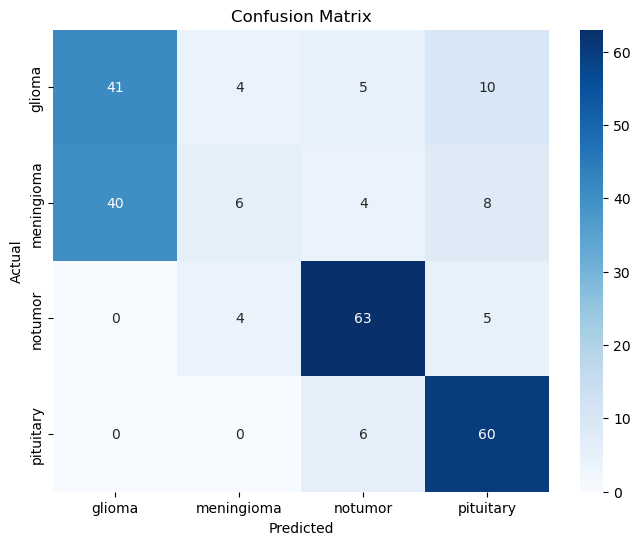

In [10]:
# Load the best saved model
custom_cnn.load_weights(checkpoint_path_custom)

# Evaluate on validation data
val_loss, val_accuracy = custom_cnn.evaluate(validation_generator, verbose=2)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Predictions for detailed analysis
validation_generator.reset()
predictions = custom_cnn.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE + 1)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification Report
display_classification_report(true_classes, predicted_classes, class_labels)

# Confusion Matrix
plot_confusion_matrix(true_classes, predicted_classes, class_labels)

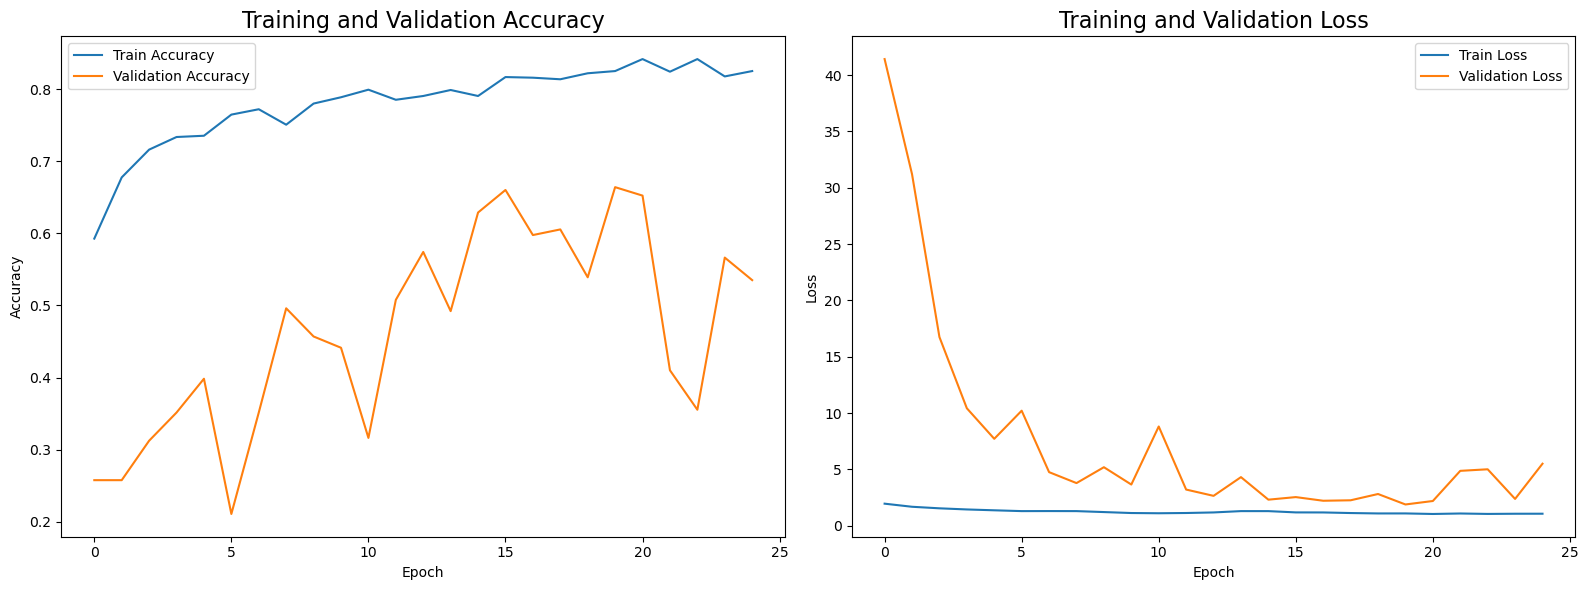

In [11]:
# Convert history to DataFrame for easier plotting
history_df_custom = pd.DataFrame(history_custom.history)

# Plot training & validation accuracy and loss
plt.figure(figsize=(16, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_df_custom['accuracy'], label='Train Accuracy')
plt.plot(history_df_custom['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_df_custom['loss'], label='Train Loss')
plt.plot(history_df_custom['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Initialize VGG16 without the top layers and freeze the convolutional base
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
vgg_base.trainable = False

# Build the transfer learning model
def build_transfer_model(base_model, num_classes=4):
    """
    Builds a transfer learning model using a pre-trained base model.
    
    Parameters:
    - base_model: Pre-trained base model
    - num_classes: Number of output classes
    
    Returns:
    - model: Compiled Keras model
    """
    model = models.Sequential(name="VGG16_Transfer_Learning")
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Instantiate the transfer learning model
transfer_model = build_transfer_model(vgg_base, num_classes=NUM_CLASSES)
transfer_model.summary()

Model: "VGG16_Transfer_Learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_4 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 32772     
                                                                 
Total params: 14,747,460
Trainable params: 32,772
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
# Define callbacks for transfer learning
checkpoint_path_vgg = 'vgg16_transfer_best_model.h5'
callbacks_list_vgg = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    callbacks.ModelCheckpoint(filepath=checkpoint_path_vgg, monitor='val_loss', save_best_only=True, verbose=1)
]

In [15]:
# Train the transfer learning model
history_transfer = transfer_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list_vgg
)

Epoch 1/25
72/72 [==============================] - ETA: 0s - loss: 1.3549 - accuracy: 0.3784
Epoch 1: val_loss improved from inf to 1.16406, saving model to vgg16_transfer_best_model.h5
72/72 [==============================] - 144s 2s/step - loss: 1.3549 - accuracy: 0.3784 - val_loss: 1.1641 - val_accuracy: 0.4922
Epoch 2/25
72/72 [==============================] - ETA: 0s - loss: 1.0420 - accuracy: 0.5647
Epoch 2: val_loss improved from 1.16406 to 1.03834, saving model to vgg16_transfer_best_model.h5
72/72 [==============================] - 144s 2s/step - loss: 1.0420 - accuracy: 0.5647 - val_loss: 1.0383 - val_accuracy: 0.5430
Epoch 3/25
72/72 [==============================] - ETA: 0s - loss: 0.9359 - accuracy: 0.6089
Epoch 3: val_loss improved from 1.03834 to 0.95143, saving model to vgg16_transfer_best_model.h5
72/72 [==============================] - 143s 2s/step - loss: 0.9359 - accuracy: 0.6089 - val_loss: 0.9514 - val_accuracy: 0.6094
Epoch 4/25
72/72 [=======================

8/8 - 14s - loss: 0.6361 - accuracy: 0.7539 - 14s/epoch - 2s/step
VGG16 Transfer - Validation Loss: 0.6361
VGG16 Transfer - Validation Accuracy: 0.7539
9/9 [==============================] - 15s 2s/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.74      0.70      0.72        60
  meningioma       0.56      0.53      0.55        58
     notumor       0.91      0.83      0.87        72
   pituitary       0.77      0.91      0.83        66

    accuracy                           0.75       256
   macro avg       0.74      0.74      0.74       256
weighted avg       0.75      0.75      0.75       256



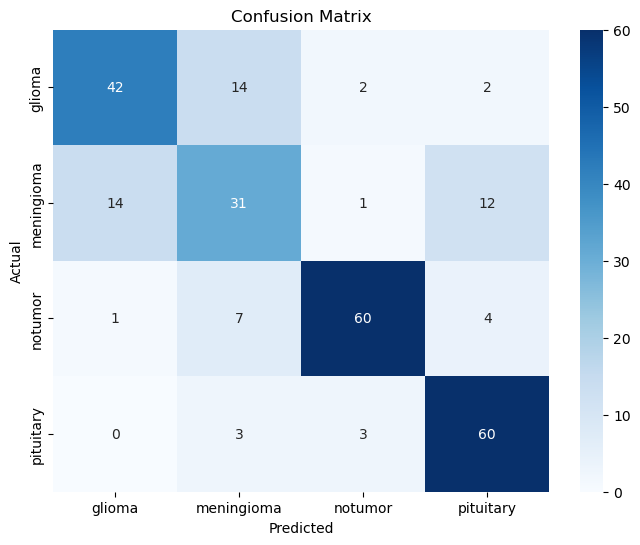

In [16]:
# Load the best saved transfer model
transfer_model.load_weights(checkpoint_path_vgg)

# Evaluate on validation data
val_loss_vgg, val_accuracy_vgg = transfer_model.evaluate(validation_generator, verbose=2)
print(f'VGG16 Transfer - Validation Loss: {val_loss_vgg:.4f}')
print(f'VGG16 Transfer - Validation Accuracy: {val_accuracy_vgg:.4f}')

# Predictions for detailed analysis
validation_generator.reset()
predictions_vgg = transfer_model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE + 1)
predicted_classes_vgg = np.argmax(predictions_vgg, axis=1)

# Classification Report and Confusion Matrix
display_classification_report(true_classes, predicted_classes_vgg, class_labels)
plot_confusion_matrix(true_classes, predicted_classes_vgg, class_labels)

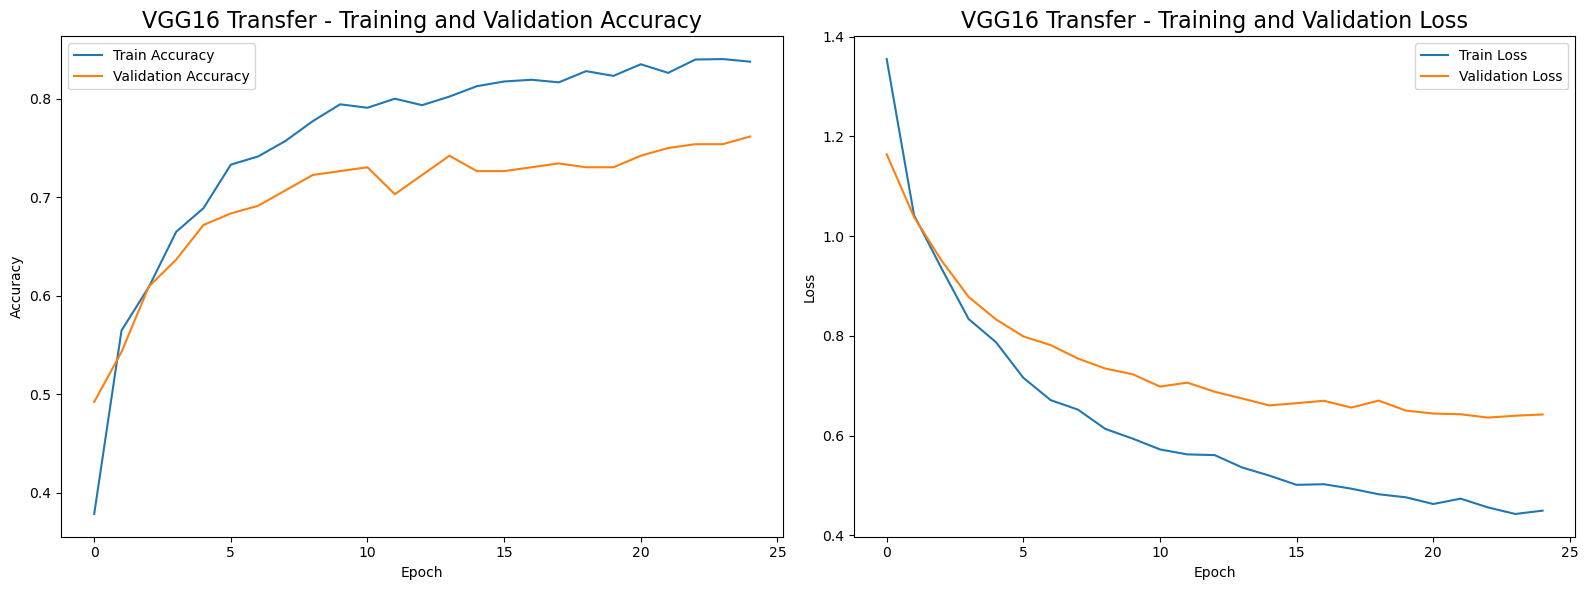

In [17]:
# Convert history to DataFrame
history_df_vgg = pd.DataFrame(history_transfer.history)

# Plot training & validation accuracy and loss
plt.figure(figsize=(16, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_df_vgg['accuracy'], label='Train Accuracy')
plt.plot(history_df_vgg['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Transfer - Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_df_vgg['loss'], label='Train Loss')
plt.plot(history_df_vgg['val_loss'], label='Validation Loss')
plt.title('VGG16 Transfer - Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Load the best transfer learning model
fine_tune_model = keras.models.load_model('vgg16_transfer_best_model.h5')
fine_tune_model.summary()

# Unfreeze some layers of the base model for fine-tuning
vgg_base_finetune = fine_tune_model.layers[0]
vgg_base_finetune.trainable = True

# Fine-tune from this layer onwards
for layer in vgg_base_finetune.layers[:7]:
    layer.trainable = False  # Freeze initial layers

# Recompile the model with a lower learning rate
fine_tune_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks for fine-tuning
checkpoint_path_finetune = 'vgg16_finetuned_best_model.h5'
callbacks_list_finetune = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    callbacks.ModelCheckpoint(filepath=checkpoint_path_finetune, monitor='val_loss', save_best_only=True, verbose=1)
]

# Fine-tune the model
fine_tune_history = fine_tune_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list_finetune,
    initial_epoch=len(history_transfer.history['loss'])  # Start from the end of previous training
)

Model: "VGG16_Transfer_Learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_4 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 32772     
                                                                 
Total params: 14,747,460
Trainable params: 32,772
Non-trainable params: 14,714,688
_________________________________________________________________


8/8 - 15s - loss: 0.6380 - accuracy: 0.7969 - 15s/epoch - 2s/step
VGG16 Fine-Tuned - Validation Loss: 0.6380
VGG16 Fine-Tuned - Validation Accuracy: 0.7969
9/9 [==============================] - 15s 2s/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.85      0.68      0.76        60
  meningioma       0.66      0.67      0.67        58
     notumor       0.88      0.92      0.90        72
   pituitary       0.78      0.88      0.83        66

    accuracy                           0.80       256
   macro avg       0.79      0.79      0.79       256
weighted avg       0.80      0.80      0.80       256



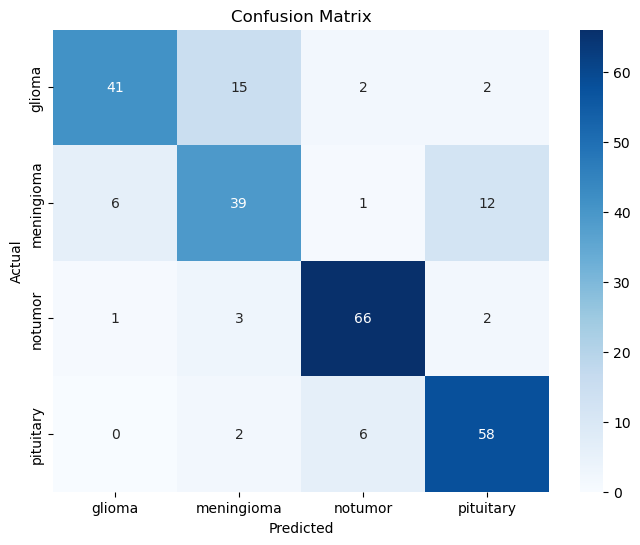

In [20]:
# Load the best fine-tuned model
fine_tune_model.load_weights(checkpoint_path_finetune)

# Evaluate on validation data
val_loss_finetune, val_accuracy_finetune = fine_tune_model.evaluate(validation_generator, verbose=2)
print(f'VGG16 Fine-Tuned - Validation Loss: {val_loss_finetune:.4f}')
print(f'VGG16 Fine-Tuned - Validation Accuracy: {val_accuracy_finetune:.4f}')

# Predictions for detailed analysis
validation_generator.reset()
predictions_finetune = fine_tune_model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE + 1)
predicted_classes_finetune = np.argmax(predictions_finetune, axis=1)

# Classification Report and Confusion Matrix
display_classification_report(true_classes, predicted_classes_finetune, class_labels)
plot_confusion_matrix(true_classes, predicted_classes_finetune, class_labels)


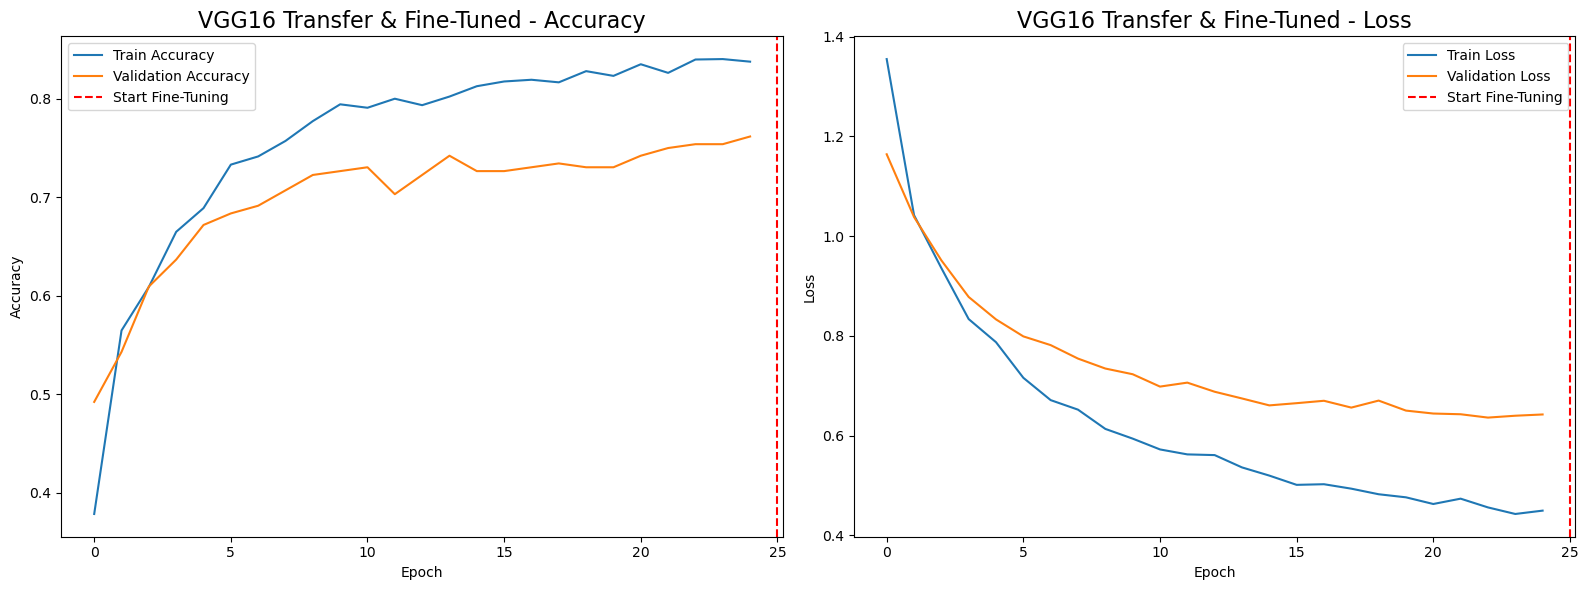

In [21]:
# Convert history to DataFrame
history_df_finetune = pd.DataFrame(fine_tune_history.history)

# Concatenate previous training history
combined_history = pd.concat([history_df_vgg, history_df_finetune], ignore_index=True)

# Plot training & validation accuracy and loss with fine-tuning markers
plt.figure(figsize=(16, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(combined_history['accuracy'], label='Train Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=len(history_df_vgg), color='r', linestyle='--', label='Start Fine-Tuning')
plt.title('VGG16 Transfer & Fine-Tuned - Accuracy', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(combined_history['loss'], label='Train Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.axvline(x=len(history_df_vgg), color='r', linestyle='--', label='Start Fine-Tuning')
plt.title('VGG16 Transfer & Fine-Tuned - Loss', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()